# Aufgabe 3: Inverse Filterung
Ist der einem aufgenommenen Bild $g$ zugrundeliegende Störfunktion $h$ und dessen Fouriertransformierte $H$ bekannt, so kann mittels *inverser Filterung* das Originalbild
\begin{align}
  \widehat{F}(u, v) &= \frac{G(u,v)}{H(u,v)}
\end{align}
rekonstruiert werden.
Dabei ist
\begin{align}
  \widehat{F}(u, v) &= F(u,v) + \frac{N(u,v)}{H(u,v)}
\end{align}
weiterhin durch einen unbekannten additiven Rauschprozess $n$ gestört.

Modellieren Sie einen selbstgewählten Störprozess (beispielsweise die durch Bewegung der Kamera während der Bildaufnahme erzeugte Unschärfe und atmosphärische Störungen, siehe Vorlesungsfolien) und simulieren Sie dessen Auswirkungen auf einigen Beispielbildern!
Versuchen Sie nun, mittels inverser Filterung das Originalbild zu rekonstruieren!
Wiederholen Sie diesen Versuch mit verschiedenen - dem eigentlichen Störprozess einhergehenden - Rauschprozessen und variieren Sie deren Intensitäten!
Beschreiben und erklären Sie Ihre Beobachtungen!

## 0. Pfade, Pakete etc.

In [1]:
import glob
import urllib.request

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import imageio
import numpy as np

import math

In [2]:
image_filter = './../material/Bilder/Pollen1.jpg'

## 1. Definition der Störprozesse

Definieren Sie den **Störprozess** als Funktion $H$ der Koordinaten $(u,v)$ im Frequenzbereich. Tipp: Verwenden Sie normalisierte Werte $\in [-1,1]$!

In [3]:
T = 1
a = b = 10
H = lambda u,v: (1 / (np.pi * (u*a + v*b) + 0.0000001)) * np.sin(np.pi * (u*a + v*b)) * np.exp(-1j * np.pi * (u*a + v*b))

Geben Sie nun einen additiven **Rauschprozess** als Funktion $N$ an, die ebenfalls im Frequenzbereich vorliegt.

In [4]:
N = lambda u,v: np.complex(np.cos(np.random.rand(1) * np.pi) + 1j * np.sin(np.random.rand(1) * np.pi)) 

## 2. Laden des Bildes

In [5]:
image_path = np.random.choice(glob.glob(image_filter))
image = imageio.imread(image_path)

Für diese Aufgabe ist es wichtig, das Bild im Fließkommaformat vorliegen zu haben. Andernfalls kann der Median nicht immer korrekt berechent werden. Konvertieren sie `image` zu einer geeigneten Repräsentation:

In [6]:
image_max = np.float32(np.max(image))  # Maximum bestimmen
image_min = np.float32(np.min(image))  # Minimum bestimmen
image = (np.float32(image) - image_min) / (image_max-image_min)

## 3. Simulation der Störung

Wir definieren zunächst eine Hilfsfunktion `ex4_apply_noise`, die ein Originalbild $f$ mit den Prozessen $H$ und $N$ stört und das gestörte Bild $g$ sowie die Fouriertransformierte $G$ zurückgibt:

In [7]:
def ex4_apply_noise(f, H, N):
    # Fouriertransformation
    F = np.fft.fftshift(np.fft.fft2(f))
    
    G = np.zeros_like(F)
    
    for u, v in np.ndindex(*f.shape):
        u_ = 2 * (float(u) / f.shape[0]) - 1.0
        v_ = 2 * (float(v) / f.shape[1]) - 1.0
        
        # Anwendung des Prozesses N und H
        G[u,v] = F[u,v] * H(u_, v_) + N(u_, v_)
    
    g = np.real(np.fft.ifft2(np.fft.ifftshift(G)))
    return G, g

Die Funktion wird nun eingesetzt, um das Bild einmal nur durch $H$ und einmal durch $H$ und $N$ zu stören.

In [8]:
G1, g1 = ex4_apply_noise(image, H, lambda u, v: 0)  # Störung nur durch H, N ist 0
G2, g2 = ex4_apply_noise(image, H, N)

Visualisieren Sie `image`, `g1` und `g2` nebeneinander:

<IPython.core.display.Javascript object>


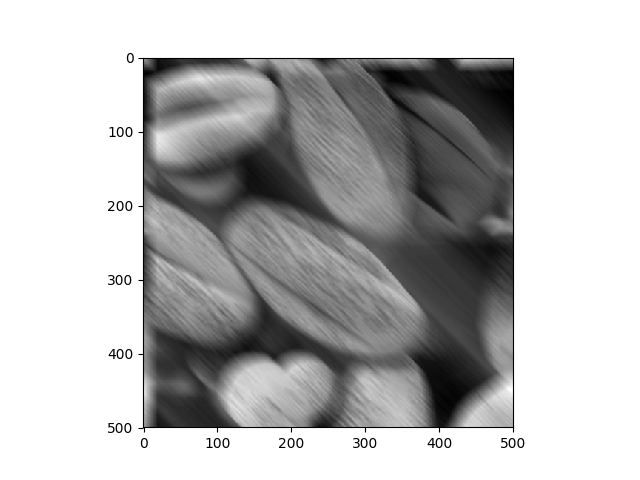

In [9]:
plt.figure()
plt.imshow(g1, cmap='gray')

<IPython.core.display.Javascript object>


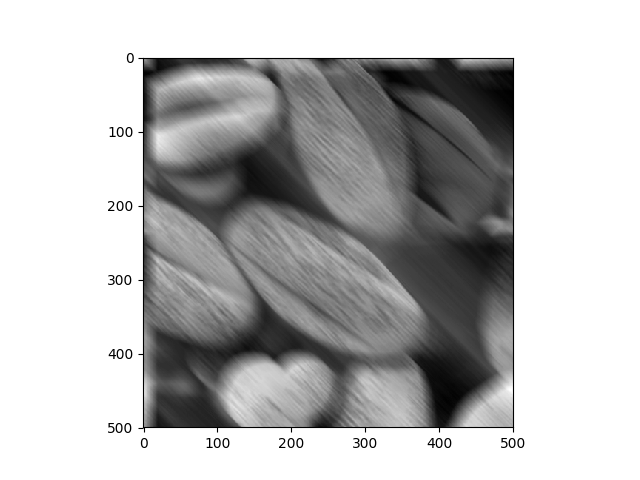

In [10]:
plt.figure()
plt.imshow(g2, cmap='gray')

<IPython.core.display.Javascript object>


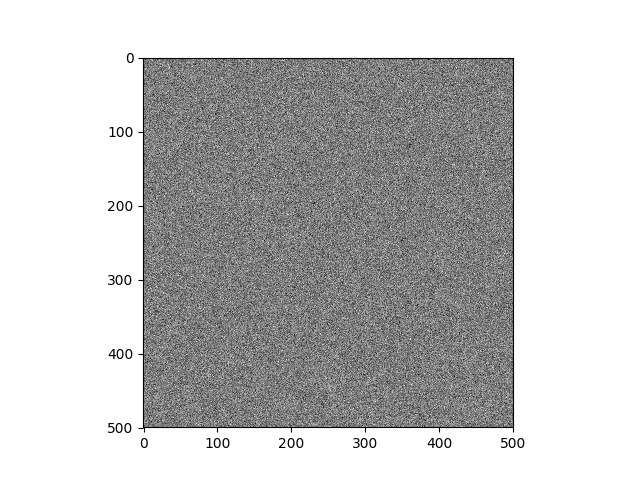

In [11]:
plt.figure()
plt.imshow(g2 - g1, cmap='gray')

## 4. Rekonstruktion
Es soll nun versucht werden, das Originalbild $f$ aus `g1` und `g2` mittels inverser Filterung wiederherzustellen. Dazu definieren wir zunächst eine Funktion `ex4_inverse_filter`, die mit Hilfe der Gleichung (1) eine solche durchführt und das entstörte Bild $f'$ zurückgibt. Dabei ist diesmal allerdings nur $H$ bekannt:

In [12]:
def ex4_inverse_filter(g, H):
    G = np.fft.fftshift(np.fft.fft2(g))
    F_hat = np.ones(G.shape, dtype=np.complex)
    for v in range(G.shape[1]):
        for u in range(G.shape[0]):
            u_ = 2 * (float(u) / g.shape[0]) - 1.0
            v_ = 2 * (float(v) / g.shape[1]) - 1.0
            
            F_hat[u, v] = G[u, v] / H(u_, v_)
    
    inf_idxs = np.argwhere(np.isinf(F_hat))
    for inf_idx in inf_idxs:
        F_hat[inf_idx[0], inf_idx[1]] = 0.0 + 0.0j
    
#     nan_idxs = np.argwhere(np.isnan(F_hat))
#     for nan_idx in nan_idxs:
#         F_hat[nan_idx[0], nan_idx[1]] = 0.0 + 0.0j
        
        
    f_ = np.real(np.fft.ifft2(np.fft.ifftshift(F_hat)))
    return f_

Die Funktion wird jetzt für `g1` und `g2` aufgerufen:

In [13]:
f1_ = ex4_inverse_filter(g1, H)
f2_ = ex4_inverse_filter(g2, H)

/Users/Oana/python_virtual_envs/rs1_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in cdouble_scalars
  if __name__ == '__main__':
/Users/Oana/python_virtual_envs/rs1_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in cdouble_scalars
  if __name__ == '__main__':


In [14]:
print(f1_)

[[-0.14292735 -0.4636858  -0.32589683 ...  0.02298109 -0.16073144
  -0.05097869]
 [-0.53208897 -0.48390676 -0.24465058 ... -0.13022693  0.00386851
   0.0275713 ]
 [-0.42944909 -0.65004753 -0.10566447 ...  0.01450696 -0.2861701
  -0.23953452]
 ...
 [-0.19268816 -0.48121439 -0.17904931 ...  0.10296372  0.23394023
   0.20635267]
 [-0.34818313 -0.58108619 -0.62321733 ...  0.1337855   0.04953137
   0.24676964]
 [-0.24007694 -0.55366461 -0.10542653 ...  0.0873965   0.32737884
   0.11376917]]


Visualisieren Sie nun das Originalbild `image` neben den Rekonstruktionen `f1_` und `f2_`:

<IPython.core.display.Javascript object>


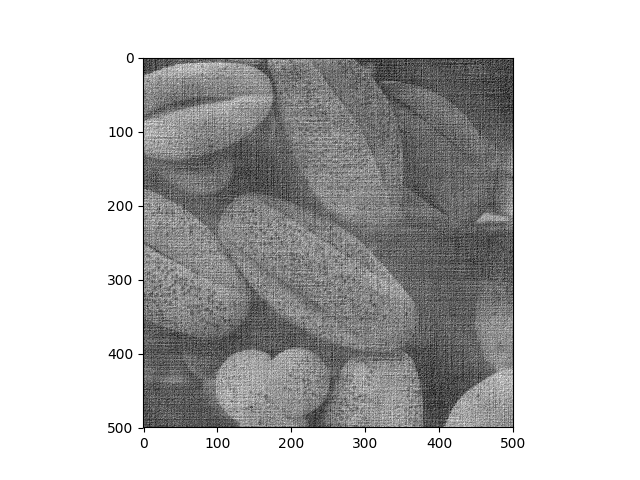

In [15]:
plt.figure()
plt.imshow(f1_, cmap='gray')

<IPython.core.display.Javascript object>


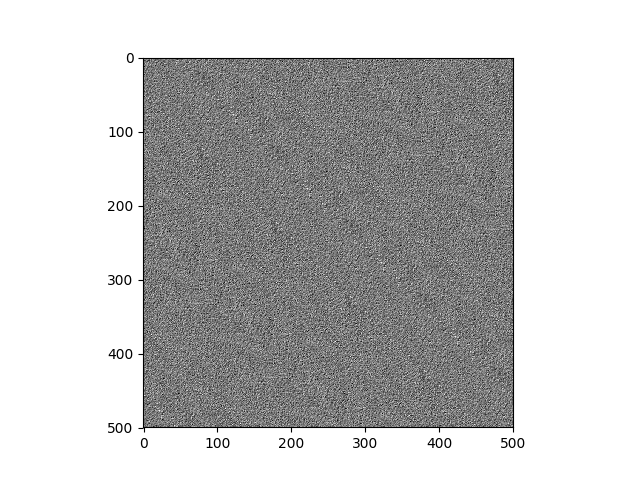

In [16]:
plt.figure()
plt.imshow(f2_, cmap='gray')